In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [31]:
# Đọc dữ liệu
df = pd.read_csv('Dataset/ev_charging_patterns.csv', header=0)
df

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,22.081164,Evening,Sunday,39.204102,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,5.067806,Evening,Tuesday,31.456375,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver
1317,User_1318,Nissan Leaf,100.000000,Station_374,New York,2024-02-24 21:00:00,2024-02-24 23:03:00,18.895102,3.267122,45.482066,37.255002,Evening,Tuesday,71.903081,78.678879,226.519258,20.358761,5.0,DC Fast Charger,Commuter
1318,User_1319,Chevy Bolt,85.000000,Station_336,San Francisco,2024-02-24 22:00:00,2024-02-24 23:20:00,13.756252,2.754527,38.148183,39.046146,Afternoon,Sunday,76.187997,65.926573,291.494076,24.134598,5.0,Level 2,Commuter


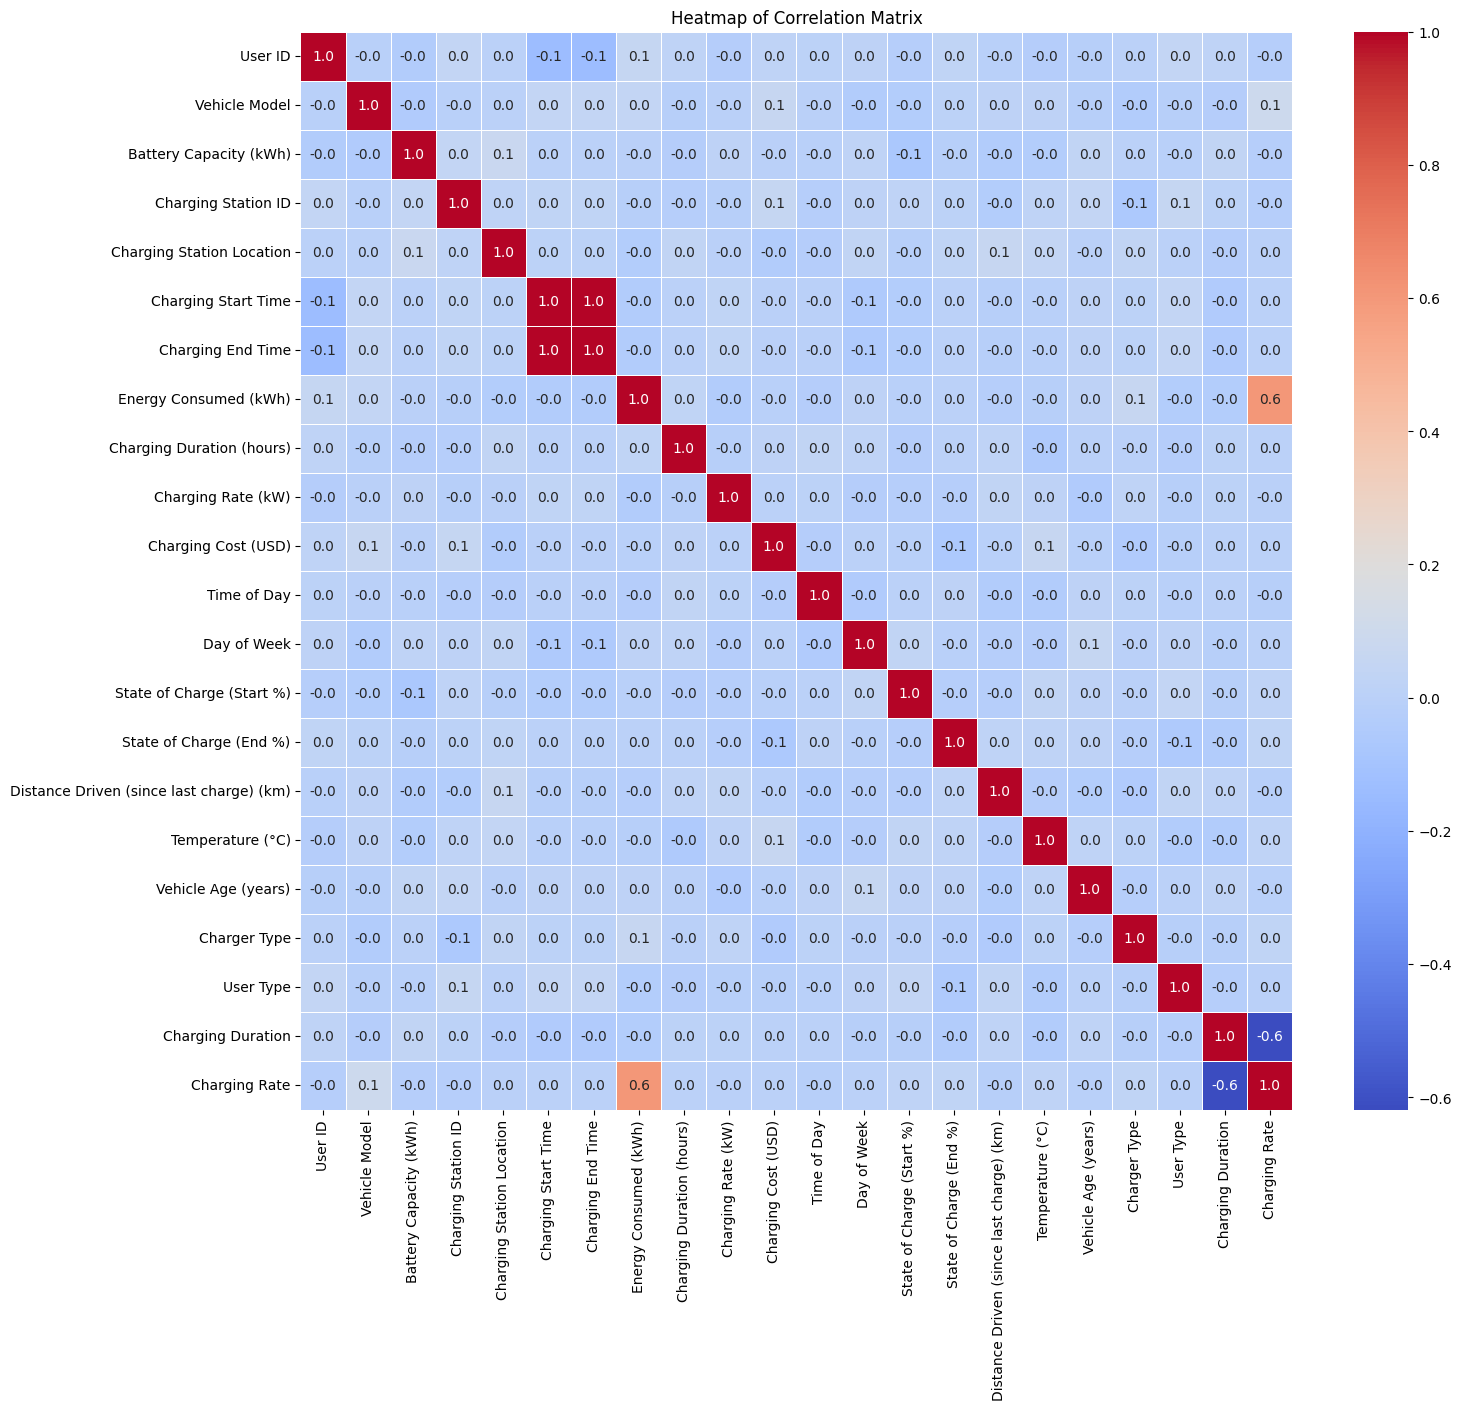

In [32]:
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])
# df['Hour'] = df['Charging Start Time'].dt.hour
# df['Month'] = df['Charging Start Time'].dt.month
# df['Year'] = df['Charging Start Time'].dt.year
df['Charging Duration'] = (df['Charging End Time'] - df['Charging Start Time']).dt.total_seconds() / 3600
df['Charging Rate'] = df['Energy Consumed (kWh)']/df['Charging Duration']
# df["Duration_Hour"] = df["Charging Duration"] * df["Hour"]
# df["Duration_Rate"] = df["Charging Duration"] * df["Charging Rate (kW)"]
# df["Hour_Rate"] = df["Hour"] * df["Charging Rate (kW)"]
df[['Charging Rate','Charging Rate (kW)']].head()
nan_col = df[list(filter(lambda col: df[col].isna().sum() > 0, df.columns))].columns
from sklearn.impute import KNNImputer

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
arr = pd.DataFrame(imputer.fit_transform(df[nan_col]),columns=nan_col)
for col in nan_col:
  df[col] = arr[col]
numerical_columns = df.select_dtypes(include=["float64"]).columns
for col in numerical_columns:
    median_val = df[col].median()
    df[col] = df[col].replace([np.inf, -np.inf], median_val)
from sklearn.preprocessing import LabelEncoder

# Vẽ biểu đồ nhiệt ma trận tương quan
label_encoder = LabelEncoder()
df_encoder = df.copy()
for col in df_encoder.select_dtypes(include=['object']).columns:
  df_encoder[col] = label_encoder.fit_transform(df_encoder[col])
corr_matrix = df_encoder.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm',fmt=".1f", linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

<p> Nhận xét: Bộ dữ liệu hầu như không có sự tương quan lớn giữa các biến, vì thế các mô hình dự đoán tuyến tính hầu như có khả năng dự đoán rất thấp. Sau khi tìm hiểu, nhóm đã chọn tích hợp các Polynominal Features trong tiền xử lý và các mô hình phi tuyến để có thể tạo được mô hình hồi quy đa thức phù hợp </p>

# Các mô hình hồi quy với tiền xử lý có Polynominal Features

# Mô hình đa thức sử dụng hồi quy tuyến tính mở rộng không gian đặc trưng bằng Polynominal Features

Best Degree: 2
Best Cross-Validated RMSE: 7.5304

Training RMSE (Best Degree): 6.8068
Training R-squared (Best Degree): 0.9039
Mean MSE (Linear Regression): 56.7062
Standard Deviation of MSE: 10.3145


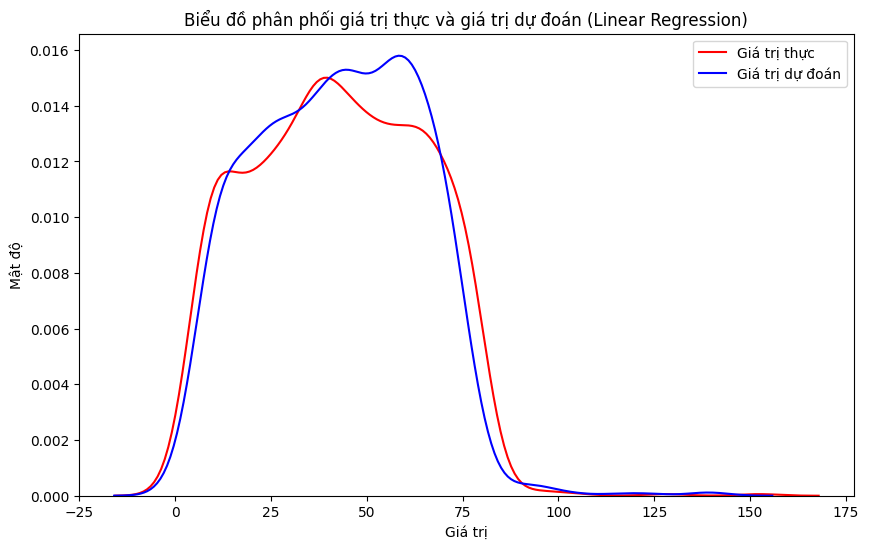

In [33]:
# Chuẩn bị dữ liệu
X = df.drop(columns=['Energy Consumed (kWh)', 'User ID', 'Charging Station ID'])
y = df['Energy Consumed (kWh)']

# Xác định các cột số và cột phân loại
numerical_columns = X.select_dtypes(include=['float64', 'int32']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Phạm vi giá trị của degree
degrees = range(1, 6)  # Bậc từ 1 đến 5

# Kết quả để lưu bậc và RMSE
best_result = {"degree": None, "rmse": float('inf')}

# Duyệt qua từng bậc
for degree in degrees:
    # Tạo preprocessor với bậc đa thức
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=degree, include_bias=False))  # Bậc đa thức
            ]), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # OneHotEncoder
        ]
    )
    
    # Tạo pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())  # Sử dụng Linear Regression thay vì Ridge
    ])
    
    # Đánh giá bằng Cross-Validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    mean_rmse = np.sqrt(-np.mean(scores))  # Tính RMSE
    
    # Cập nhật nếu RMSE tốt hơn
    if mean_rmse < best_result["rmse"]:
        best_result["degree"] = degree
        best_result["rmse"] = mean_rmse

# In kết quả tốt nhất
print(f"Best Degree: {best_result['degree']}")
print(f"Best Cross-Validated RMSE: {best_result['rmse']:.4f}")

# Huấn luyện lại với giá trị tốt nhất
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=best_result['degree'], include_bias=False))
        ]), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('regressor', LinearRegression())  # Linear Regression
])

# Huấn luyện mô hình
final_pipeline.fit(X, y)

# Dự đoán trên dữ liệu huấn luyện
predictions = final_pipeline.predict(X)

# Đánh giá kết quả trên dữ liệu huấn luyện
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)

print(f"\nTraining RMSE (Best Degree): {rmse:.4f}")
print(f"Training R-squared (Best Degree): {r2:.4f}")

# Sử dụng cross_val_score để thực hiện K-fold cross validation
k = 5  # Số lượng folds
cv_scores = cross_val_score(final_pipeline, X, y, cv=k, scoring='neg_mean_squared_error')

# Tính toán MSE trung bình và độ lệch chuẩn
mean_mse = -cv_scores.mean()
std_mse = cv_scores.std()

print(f'Mean MSE (Linear Regression): {mean_mse:.4f}')
print(f'Standard Deviation of MSE: {std_mse:.4f}')

# Vẽ biểu đồ so sánh giữa giá trị thực và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='r', label='Giá trị thực')
sns.kdeplot(predictions, color='b', label='Giá trị dự đoán')
plt.title('Biểu đồ phân phối giá trị thực và giá trị dự đoán (Linear Regression)')
plt.xlabel('Giá trị')
plt.ylabel('Mật độ')
plt.legend()
plt.show()

# Mô hình đa thức sử dụng hồi quy Ridge mở rộng không gian đặc trưng bằng Polynominal Features

Best Degree: 2
Best Alpha: 0.46415888336127775
Best Cross-Validated RMSE: 7.5303

Overall RMSE (Best Degree & Alpha): 6.8070
R-squared (Best Degree & Alpha): 0.9039
Mean MSE: 56.70565336351437
Standard Deviation of MSE: 10.197692254366505


C:\Users\aboyw\AppData\Local\Temp\ipykernel_13780\2118388086.py:91: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, hist=False, kde=True, color='r', label='Giá trị thực')
C:\Users\aboyw\AppData\Local\Temp\ipykernel_13780\2118388086.py:92: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

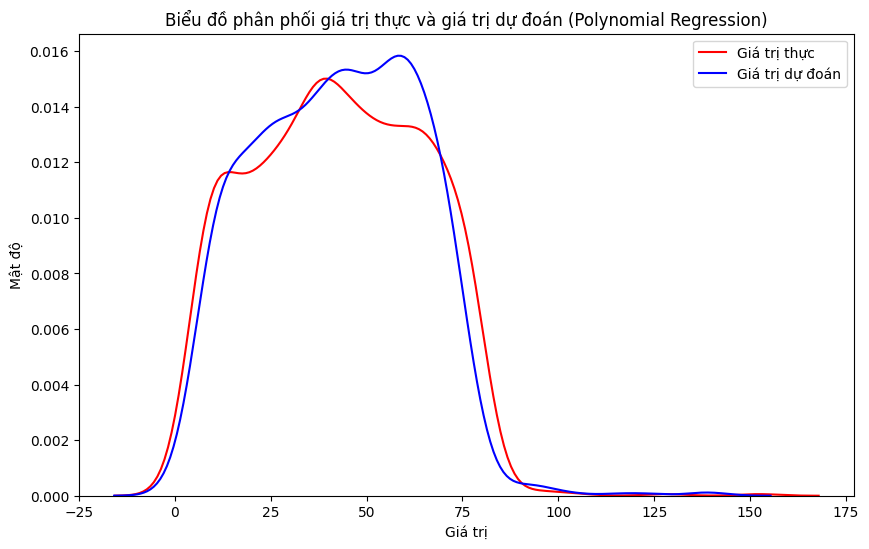

In [28]:
X = df.drop(columns=['Energy Consumed (kWh)', 'User ID', 'Charging Station ID'])
y = df['Energy Consumed (kWh)']

# Xác định các cột số và cột phân loại
numerical_columns = X.select_dtypes(include=['float64', 'int32']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Phạm vi giá trị của degree và alpha
degrees = range(1, 6)  # Bậc từ 1 đến 5
alphas = np.logspace(-3, 3, 10)  

# Kết quả để lưu bậc, alpha và RMSE
best_result = {"degree": None, "alpha": None, "rmse": float('inf')}

# Duyệt qua từng bậc và alpha
for degree in degrees:
    for alpha in alphas:
        # Tạo preprocessor với bậc đa thức
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree, include_bias=False))  # Bậc đa thức
                ]), numerical_columns),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # OneHotEncoder
            ]
        )
        
        # Tạo pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=alpha))
        ])
        
        # Đánh giá bằng Cross-Validation
        scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
        mean_rmse = np.sqrt(-np.mean(scores))  # Tính RMSE
        
        # Cập nhật nếu RMSE tốt hơn
        if mean_rmse < best_result["rmse"]:
            best_result["degree"] = degree
            best_result["alpha"] = alpha
            best_result["rmse"] = mean_rmse

# In kết quả tốt nhất
print(f"Best Degree: {best_result['degree']}")
print(f"Best Alpha: {best_result['alpha']}")
print(f"Best Cross-Validated RMSE: {best_result['rmse']:.4f}")

# Huấn luyện lại với giá trị tốt nhất
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=best_result['degree'], include_bias=False))
        ]), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('regressor', Ridge(alpha=best_result['alpha']))
])

final_pipeline.fit(X, y)

# Đánh giá trên toàn bộ tập dữ liệu
predictions = final_pipeline.predict(X)

# Đánh giá hiệu suất mô hình trên toàn bộ dữ liệu
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)

print(f"\nOverall RMSE (Best Degree & Alpha): {rmse:.4f}")
print(f"R-squared (Best Degree & Alpha): {r2:.4f}")

# Sử dụng cross_val_score để thực hiện K-fold cross validation
k = 5  # Số lượng folds
cv_scores = cross_val_score(final_pipeline, X, y, cv=k, scoring='neg_mean_squared_error')

# Tính toán MSE trung bình và độ lệch chuẩn
mean_mse = -cv_scores.mean()
std_mse = cv_scores.std()

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

# Vẽ biểu đồ so sánh giữa giá trị thực và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.distplot(y, hist=False, kde=True, color='r', label='Giá trị thực')
sns.distplot(predictions, hist=False, kde=True, color='b', label='Giá trị dự đoán')
plt.title('Biểu đồ phân phối giá trị thực và giá trị dự đoán (Polynomial Regression)')
plt.xlabel('Giá trị')
plt.ylabel('Mật độ')
plt.legend()
plt.show()

## Nhận xét: Việc sử dụng các đặc trưng đa thức trong tiền xử lý các mô hình để mở rộng không gian đặc trưng:
### Mở rộng được khả năng dự đoán trong trường hợp bộ dữ liệu không có quan hệ tuyến tính rõ ràng.
### Khả năng dự đoán của của hai mô hình là gần như nhau, tuy nhiên, trong 2 mô hình, nếu sử dụng hồi quy Ridge thì mô hình có thể dễ dàng tinh chỉnh hơn, giảm thiểu overfiting. 

# Các mô hình phi tuyến tính

# Mô hình Decision Tree


Overall RMSE (Decision Tree): 4.3272
Overall R-squared (Decision Tree): 0.9612
Mean MSE (Decision Tree): 58.7805
Standard Deviation of MSE: 11.2495


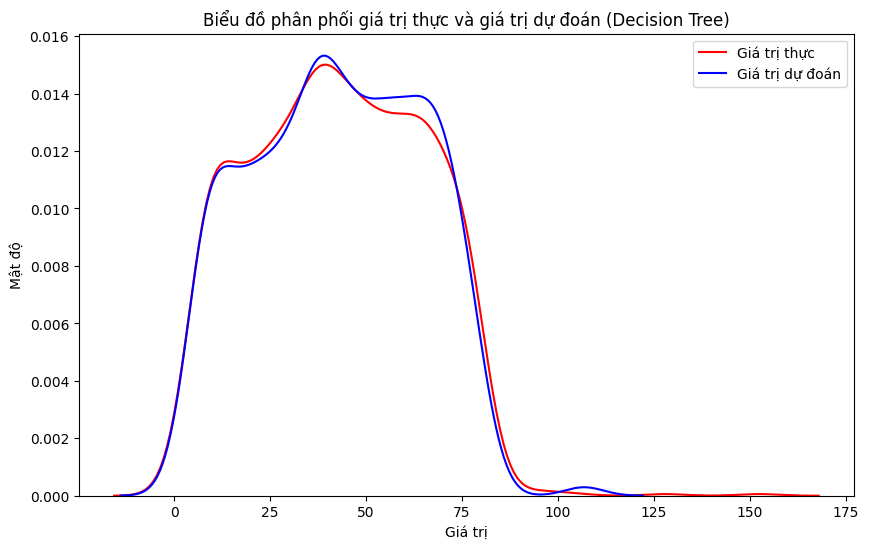

In [41]:
# Chuẩn bị preprocessor cho các cột số và cột danh mục
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Tạo pipeline với RandomForestRegressor
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5))  # Điều chỉnh tham số
])

# Huấn luyện mô hình trên toàn bộ dữ liệu
final_pipeline.fit(X, y)

# Dự đoán trên toàn bộ dữ liệu
predictions = final_pipeline.predict(X)

# Đánh giá hiệu suất mô hình trên toàn bộ dữ liệu
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)

print(f"\nOverall RMSE (Decision Tree): {rmse:.4f}")
print(f"Overall R-squared (Decision Tree): {r2:.4f}")

# Sử dụng cross_val_score để thực hiện K-fold cross validation
k = 5  # Số lượng folds
cv_scores = cross_val_score(final_pipeline, X, y, cv=k, scoring='neg_mean_squared_error')

# Tính toán MSE trung bình và độ lệch chuẩn
mean_mse = -cv_scores.mean()
std_mse = cv_scores.std()

print(f'Mean MSE (Decision Tree): {mean_mse:.4f}')
print(f'Standard Deviation of MSE: {std_mse:.4f}')

# Vẽ biểu đồ so sánh giữa giá trị thực và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='r', label='Giá trị thực')
sns.kdeplot(predictions, color='b', label='Giá trị dự đoán')
plt.title('Biểu đồ phân phối giá trị thực và giá trị dự đoán (Decision Tree)')
plt.xlabel('Giá trị')
plt.ylabel('Mật độ')
plt.legend()
plt.show()

# Mô hình Random Forrest


Overall RMSE (Random Forest): 2.2193
Overall R-squared (Random Forest): 0.9898
Mean MSE (Random Forest): 34.9494
Standard Deviation of MSE: 5.3803


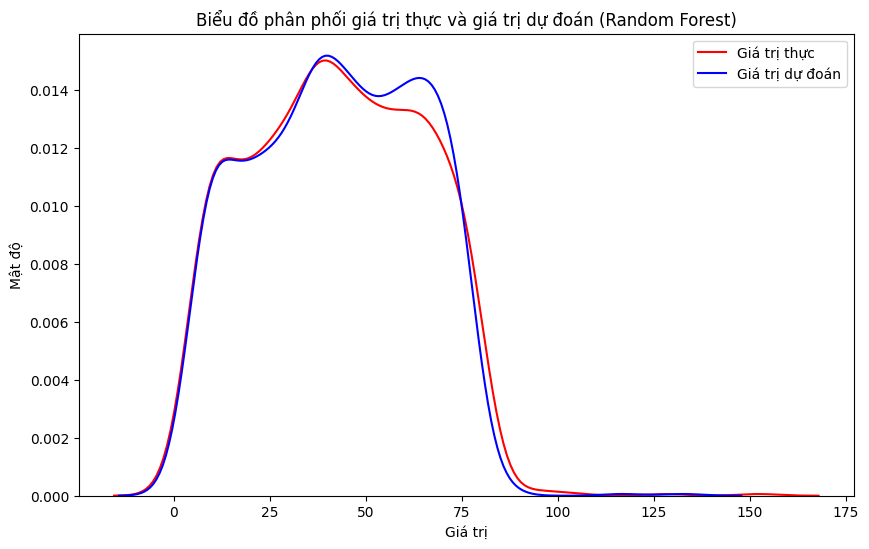

In [29]:
# Chuẩn bị preprocessor cho các cột số và cột danh mục
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Tạo pipeline với RandomForestRegressor
final_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))  # Thay Decision Tree bằng Random Forest
])

# Huấn luyện mô hình trên toàn bộ dữ liệu
final_pipeline.fit(X, y)

# Dự đoán trên toàn bộ dữ liệu
predictions = final_pipeline.predict(X)

# Đánh giá hiệu suất mô hình trên toàn bộ dữ liệu
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)

print(f"\nOverall RMSE (Random Forest): {rmse:.4f}")
print(f"Overall R-squared (Random Forest): {r2:.4f}")

# Sử dụng cross_val_score để thực hiện K-fold cross validation
k = 5  # Số lượng folds
cv_scores = cross_val_score(final_pipeline, X, y, cv=k, scoring='neg_mean_squared_error')

# Tính toán MSE trung bình và độ lệch chuẩn
mean_mse = -cv_scores.mean()
std_mse = cv_scores.std()

print(f'Mean MSE (Random Forest): {mean_mse:.4f}')
print(f'Standard Deviation of MSE: {std_mse:.4f}')

# Vẽ biểu đồ so sánh giữa giá trị thực và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='r', label='Giá trị thực')
sns.kdeplot(predictions, color='b', label='Giá trị dự đoán')
plt.title('Biểu đồ phân phối giá trị thực và giá trị dự đoán (Random Forest)')
plt.xlabel('Giá trị')
plt.ylabel('Mật độ')
plt.legend()
plt.show()

## Nhận xét: Mối quan hệ phi tuyến tính của các đặc trưng trong bộ dữ liệu được thể hiện rõ bởi hai mô hình Decision Tree và Random Forrest với hiệu suất gần như nhau. Thông số đánh giá cross-validation tương đối tốt, cho thấy ít có khả năng xảy ra overfitting. Tuy nhiên, mô hình Random Forrest sẽ dễ tinh chỉnh hơn để giảm thiểu tối đa khả năng overfitting.
## Trong cả 4 mô hình, việc sử dụng các mô hình phi tuyến tính vẫn tốt hơn so với việc mở rộng không gian đặc trưng của các mô hình dự đoán tuyến tính.Đối với bộ dữ liệu này, Random Forrest có hiệu suất tốt nhất.